In [1]:
import pandas as pd

df = pd.read_csv('../mix_balanced.csv', sep=';')
df.head()

,score,content,label
0,5.0,Thank you aplikasinya ga cuma cari loker aja c...,positif
1,1.0,"Aplikasi ga jelass, bikin ribet",negatif
2,5.0,App yang bagus untuk pencari peluang dan ilmu ...,positif
3,1.0,Setiap buka aplikasi LinkedIn langsung keluar ...,negatif
4,1.0,Linked bukan menyediakan info lowongan kerja t...,negatif


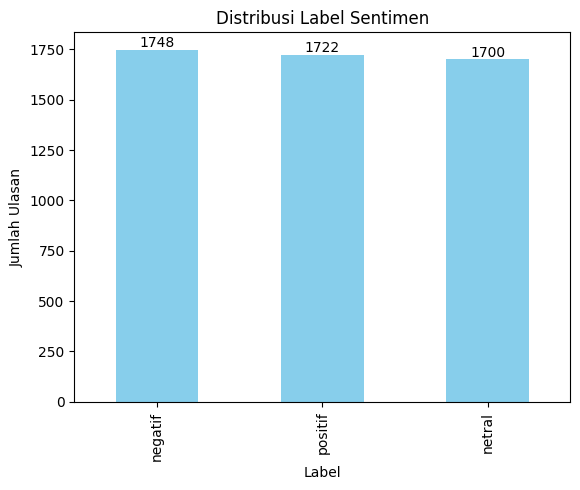

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Hitung jumlah masing-masing label
label_counts = df['label'].value_counts()

# Buat grafik batang
ax = label_counts.plot(kind='bar', color='skyblue')

# Tambahkan jumlah di atas setiap batang
for i in ax.containers:
    ax.bar_label(i)

plt.title('Distribusi Label Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Ulasan')
plt.show()

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import json

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory    
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory    
import re    
import json    
import pandas as pd    
from nltk.tokenize import word_tokenize    

# Inisialisasi stemmer dan stopwords dari Sastrawi    
factory = StemmerFactory()    
stemmer = factory.create_stemmer()    
stopword_factory = StopWordRemoverFactory()    
stopwords_id = set(stopword_factory.get_stop_words())    

# Muat kamus slang dari file    
with open('../slang_words.txt', 'r', encoding='utf-8') as file:    
    slang_dict = json.load(file)    

def clean_text(text):    
    if not isinstance(text, str):    
        return ""    
    text = text.lower()  # lowercase dulu
    text = re.sub(r'\d+', '', text)    
    text = re.sub(r'[^\w\s]', ' ', text)    
    text = re.sub(r'\s+', ' ', text)    
    text = text.strip()    
    text = re.sub(r'[^\x00-\x7F]+', '', text)    
    return text    

def normalize_slang(text):    
    tokens = text.split()    
    normalized_tokens = [slang_dict.get(token, token) for token in tokens]    
    return ' '.join(normalized_tokens)    

def tokenize_text(text):    
    return word_tokenize(text)    

def remove_stopwords(tokens):    
    return [word for word in tokens if word not in stopwords_id and len(word) > 1]  # Filter token satu karakter    

def stemming_tokens(tokens):    
    return [stemmer.stem(token) for token in tokens]    

# Proses preprocessing    
df['cleaned_review'] = df['content'].apply(clean_text)    
df['normalized_review'] = df['cleaned_review'].apply(normalize_slang)    
df['tokens'] = df['normalized_review'].apply(tokenize_text)    
df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)    
df['stemmed_tokens'] = df['filtered_tokens'].apply(stemming_tokens)    
df['stemmed_review'] = df['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))    

# Hapus baris yang kosong setelah preprocessing (misal hasilnya kosong)
df_clean = df[df['stemmed_review'].str.strip() != ''].copy()    

# Hapus baris NaN jika ada
df_clean.dropna(subset=['stemmed_review'], inplace=True)    

# Simpan hasil preprocessing
df_clean.to_csv('preprocessed_data.csv', index=False)

In [5]:
# Load preprocessed data
preprocessed_df = pd.read_csv('preprocessed_data.csv')

In [6]:
from IPython.display import display    

# Atur opsi tampilan pandas untuk menampilkan seluruh teks dan baris    
pd.set_option('display.max_colwidth', None)  # Tidak membatasi lebar kolom    
pd.set_option('display.max_rows', None)      # Menampilkan seluruh baris    

# Tampilkan beberapa baris dari DataFrame yang sudah diproses    
display(preprocessed_df[['content', 'cleaned_review', 'normalized_review', 'tokens', 'filtered_tokens', 'stemmed_tokens', 'stemmed_review']].head(10))  

,content,cleaned_review,normalized_review,tokens,filtered_tokens,stemmed_tokens,stemmed_review
0,Thank you aplikasinya ga cuma cari loker aja cuma buka relasi lebih luas. ðŸ˜ŠðŸ‘ðŸ‘ðŸ‘,thank you aplikasinya ga cuma cari loker aja cuma buka relasi lebih luas,thank you aplikasinya tidak cuma cari loker saja cuma buka relasi lebih luas,"['thank', 'you', 'aplikasinya', 'tidak', 'cuma', 'cari', 'loker', 'saja', 'cuma', 'buka', 'relasi', 'lebih', 'luas']","['thank', 'you', 'aplikasinya', 'cuma', 'cari', 'loker', 'cuma', 'buka', 'relasi', 'lebih', 'luas']","['thank', 'you', 'aplikasi', 'cuma', 'cari', 'loker', 'cuma', 'buka', 'relasi', 'lebih', 'luas']",thank you aplikasi cuma cari loker cuma buka relasi lebih luas
1,"Aplikasi ga jelass, bikin ribet",aplikasi ga jelass bikin ribet,aplikasi tidak jelass bikin ribet,"['aplikasi', 'tidak', 'jelass', 'bikin', 'ribet']","['aplikasi', 'jelass', 'bikin', 'ribet']","['aplikasi', 'jelass', 'bikin', 'ribet']",aplikasi jelass bikin ribet
2,App yang bagus untuk pencari peluang dan ilmu Pokoknya good ðŸ‘banyak wawasan pengetahuan dari para profesional,app yang bagus untuk pencari peluang dan ilmu pokoknya good banyak wawasan pengetahuan dari para profesional,app yang bagus untuk pencari peluang dan ilmu pokoknya good banyak wawasan pengetahuan dari para profesional,"['app', 'yang', 'bagus', 'untuk', 'pencari', 'peluang', 'dan', 'ilmu', 'pokoknya', 'good', 'banyak', 'wawasan', 'pengetahuan', 'dari', 'para', 'profesional']","['app', 'bagus', 'pencari', 'peluang', 'ilmu', 'pokoknya', 'good', 'banyak', 'wawasan', 'pengetahuan', 'profesional']","['app', 'bagus', 'cari', 'peluang', 'ilmu', 'pokok', 'good', 'banyak', 'wawas', 'tahu', 'profesional']",app bagus cari peluang ilmu pokok good banyak wawas tahu profesional
3,Setiap buka aplikasi LinkedIn langsung keluar lagi buka lagi aplikasi nya keluar lagi kesel banget,setiap buka aplikasi linkedin langsung keluar lagi buka lagi aplikasi nya keluar lagi kesel banget,setiap buka aplikasi linkedin langsung keluar lagi buka lagi aplikasi nya keluar lagi kesel banget,"['setiap', 'buka', 'aplikasi', 'linkedin', 'langsung', 'keluar', 'lagi', 'buka', 'lagi', 'aplikasi', 'nya', 'keluar', 'lagi', 'kesel', 'banget']","['buka', 'aplikasi', 'linkedin', 'langsung', 'keluar', 'buka', 'aplikasi', 'nya', 'keluar', 'kesel', 'banget']","['buka', 'aplikasi', 'linkedin', 'langsung', 'keluar', 'buka', 'aplikasi', 'nya', 'keluar', 'kesel', 'banget']",buka aplikasi linkedin langsung keluar buka aplikasi nya keluar kesel banget
4,"Linked bukan menyediakan info lowongan kerja tapi linked kebanyakan menyediakan info jualan iklan produk perusahan ,pengaturan aflikasi kamu ini rumit ribet tak praktis tak simpel tak banyak aturan ðŸ˜ŽðŸ‘Ž",linked bukan menyediakan info lowongan kerja tapi linked kebanyakan menyediakan info jualan iklan produk perusahan pengaturan aflikasi kamu ini rumit ribet tak praktis tak simpel tak banyak aturan,linked bukan menyediakan informasi lowongan kerja tetapi linked kebanyakan menyediakan informasi jualan iklan produk perusahan pengaturan aflikasi kamu ini rumit ribet tidak praktis tidak simpel tidak banyak aturan,"['linked', 'bukan', 'menyediakan', 'informasi', 'lowongan', 'kerja', 'tetapi', 'linked', 'kebanyakan', 'menyediakan', 'informasi', 'jualan', 'iklan', 'produk', 'perusahan', 'pengaturan', 'aflikasi', 'kamu', 'ini', 'rumit', 'ribet', 'tidak', 'praktis', 'tidak', 'simpel', 'tidak', 'banyak', 'aturan']","['linked', 'bukan', 'menyediakan', 'informasi', 'lowongan', 'kerja', 'linked', 'kebanyakan', 'menyediakan', 'informasi', 'jualan', 'iklan', 'produk', 'perusahan', 'pengaturan', 'aflikasi', 'kamu', 'rumit', 'ribet', 'praktis', 'simpel', 'banyak', 'aturan']","['linked', 'bukan', 'sedia', 'informasi', 'lowong', 'kerja', 'linked', 'banyak', 'sedia', 'informasi', 'jual', 'iklan', 'produk', 'usah', 'atur', 'aflikasi', 'kamu', 'rumit', 'ribet', 'praktis', 'simpel', 'banyak', 'atur']",linked bukan sedia informasi lowong kerja linked banyak sedia inform

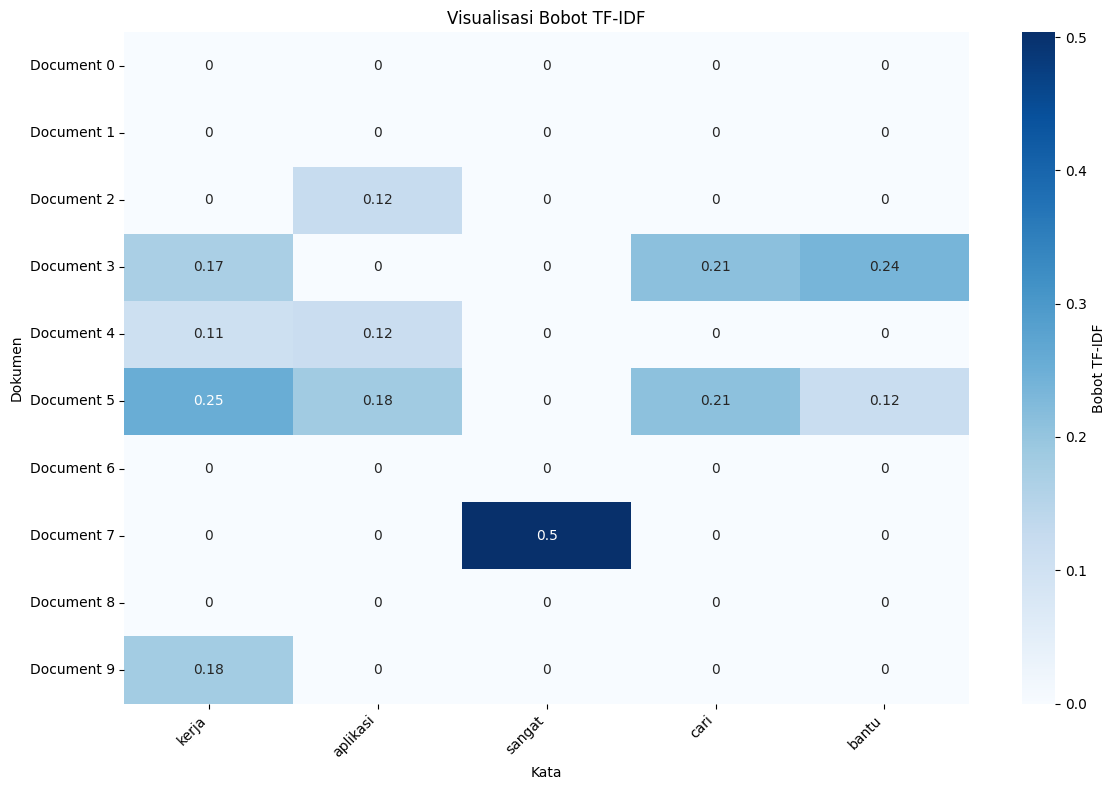

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.model_selection import train_test_split  
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Misalkan preprocessed_df adalah DataFrame Anda dengan kolom 'stemmed_review' dan 'label'  

# Split data menjadi training dan testing  
X_train, X_test, y_train, y_test = train_test_split(  
    preprocessed_df['stemmed_review'], preprocessed_df['label'], test_size=0.2, random_state=42  
)  

# Inisialisasi TF-IDF Vectorizer  
tfidf_vectorizer = TfidfVectorizer()  

# Fit dan transform data training  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  

# Transform data testing  
X_test_tfidf = tfidf_vectorizer.transform(X_test)  

# Konversi sparse matrix ke DataFrame  
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())  

# Tambahkan kolom untuk dokumen  
tfidf_df['Document'] = [f'Document {i}' for i in range(tfidf_df.shape[0])]  
tfidf_df.set_index('Document', inplace=True)  

# Hitung rata-rata skor TF-IDF untuk setiap kata  
tfidf_means = tfidf_df.mean(axis=0)  

# Ambil 5 kata dengan skor TF-IDF tertinggi  
top_words = tfidf_means.nlargest(5).index  
tfidf_df_subset = tfidf_df[top_words].head(10)  # Ambil hanya 10 baris  

# Buat heatmap untuk 5 kata teratas  
plt.figure(figsize=(12, 8))  
sns.heatmap(tfidf_df_subset, annot=True, cmap='Blues', cbar_kws={'label': 'Bobot TF-IDF'})  
plt.title('Visualisasi Bobot TF-IDF')  
plt.xlabel('Kata')  
plt.ylabel('Dokumen')  
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()  

In [8]:
import joblib

# Simpan TfidfVectorizer ke file
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

print("TfidfVectorizer telah disimpan.")

TfidfVectorizer telah disimpan.


In [9]:
import numpy as np  
import pandas as pd  
from sklearn.ensemble import ExtraTreesClassifier  
from sklearn.model_selection import cross_val_score, KFold    

# Model Extra Trees  
model = ExtraTreesClassifier(class_weight='balanced')  

# Inisialisasi KFold    
kf = KFold(n_splits=5, shuffle=True, random_state=42)    

# Terapkan cross-validation    
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf)    

# Tampilkan hasil cross-validation dalam bentuk tabel  
cv_results = pd.DataFrame({  
    'Fold': range(1, len(cv_scores) + 1),  # Menggunakan range untuk nomor fold  
    'Score': cv_scores  
})  

# Menambahkan kolom untuk rata-rata  
mean_score = np.mean(cv_scores)  # Hitung rata-rata dari skor  
cv_results.loc[len(cv_results)] = ['Mean', mean_score]  # Tambahkan baris rata-rata  

# Tampilkan hasil cross-validation  
print(cv_results)  

   Fold     Score
0     1  0.909420
1     2  0.904474
2     3  0.900846
3     4  0.898428
4     5  0.909311
5  Mean  0.904496


              precision    recall  f1-score   support

     negatif       0.91      0.91      0.91       329
      netral       0.94      0.92      0.93       342
     positif       0.91      0.94      0.93       363

    accuracy                           0.92      1034
   macro avg       0.92      0.92      0.92      1034
weighted avg       0.92      0.92      0.92      1034



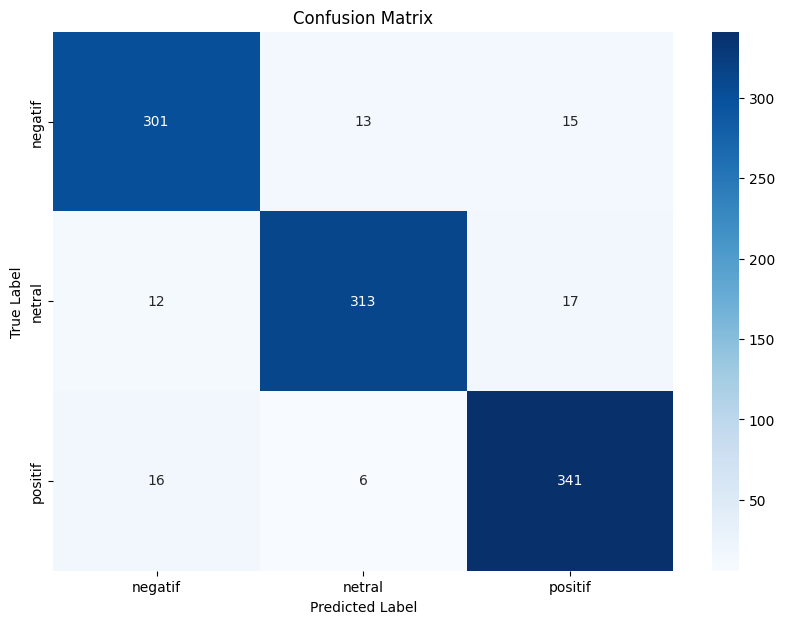

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fitting model pada data pelatihan
model.fit(X_train_tfidf, y_train)

# Prediksi pada data testing (gunakan representasi TF-IDF dari data testing)
y_pred = model.predict(X_test_tfidf)

# Evaluasi model dengan classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
import joblib

# Save the model to a file
joblib.dump(model, 'extra_trees_model.joblib')

# To load the model later:
# model = joblib.load('extra_trees_model.joblib')

['extra_trees_model.joblib']

In [12]:
# Simpan ulasan asli dari X_test ke dalam variabel
original_reviews = df.loc[X_test.index, 'content']

# Membuat DataFrame dari hasil prediksi
df_results = pd.DataFrame({
    'Review Asli': original_reviews,  # Menggunakan teks ulasan asli
    'Label Asli': y_test,             # Label asli
    'Prediksi': y_pred                # Label yang diprediksi oleh model
})

# Filter untuk data yang salah diprediksi
df_misclassified = df_results[df_results['Label Asli'] != df_results['Prediksi']]

# Tampilkan data yang salah diprediksi dalam bentuk tabel
print("Data yang salah diprediksi:")
display(df_misclassified)  # Menggunakan display untuk tabel interaktif

Data yang salah diprediksi:


,Review Asli,Label Asli,Prediksi
1988,Apakah tidak ada bahasa indonesia nya apa saat di home. Selalu bahasa english,netral,negatif
1235,"terimakasih linkedin sudah memberikan saya kesempatan mendapatkan pekerjaan 10 bulan lalu, orang2 di linkedin juga seru2 kok, dan gapernah kecewa sama aplikasi ini selama pemakaian. jd aplikasi pertama yg sering saya buka dan schroll setiap harinya",positif,negatif
1662,semoga terbantu dengan adanya aplikasi ini untuk yang sedang membutuhkan pekerjaan.,netral,positif
2420,"Ngelamarnya knpa ga semuannya di indeed, males klo di alihkan ke blogoo -.-",negatif,netral
2807,KURANG BAGUS GAK PAHAM GIMANA CARA NYA GAK NGERTI JUGA GIMANA CARA NYA?ðŸ˜ž,negatif,netral
1055,LinkedIn keren dgn updatean baru.. Bisa melihat orang hebat dan banyak lowongan pekerjaan nya,positif,netral
2226,"Aplikasinya bagus, tapi jarang bgt feed back dari perusahaan nya, terimakasi Indeed",netral,positif
227,"Di sini saya ingin belajar cara menghasilkan uang, dan saya butuh bimbingan dari admin, soal nya saya bodoh di bidang ini, ( teknolgi), Terima kasih, mohon bantuannya.",netral,negatif
3306,Seharusnya aplikasi ini bagus ya tpi lama bgt panggilan interview nya setidaknya bisa lebih cepat untuk memberikan informasi nya.,negatif,positif
279,Saya suka saya suka tapi penggunanya 30 mb yah biar hemat kuota data,positif,negatif
